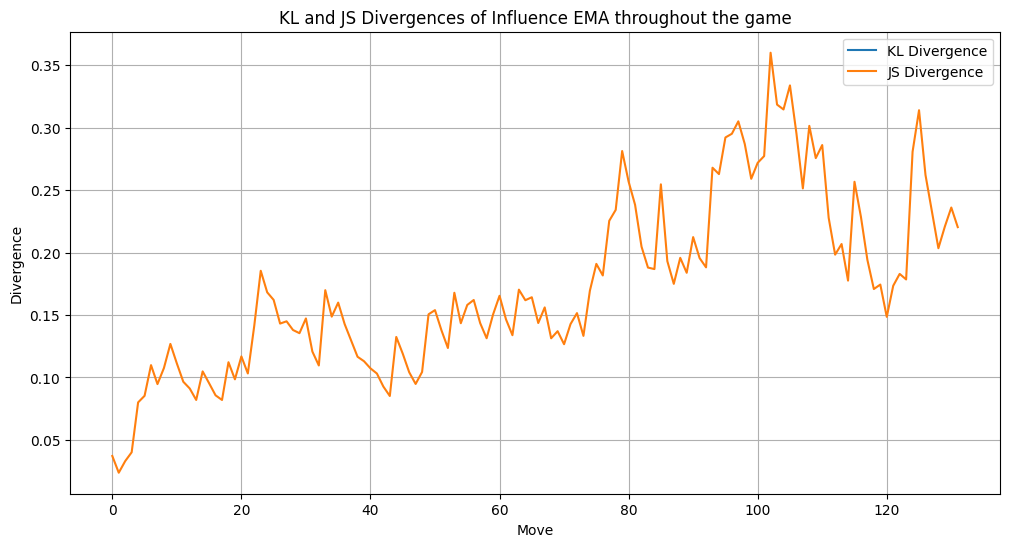

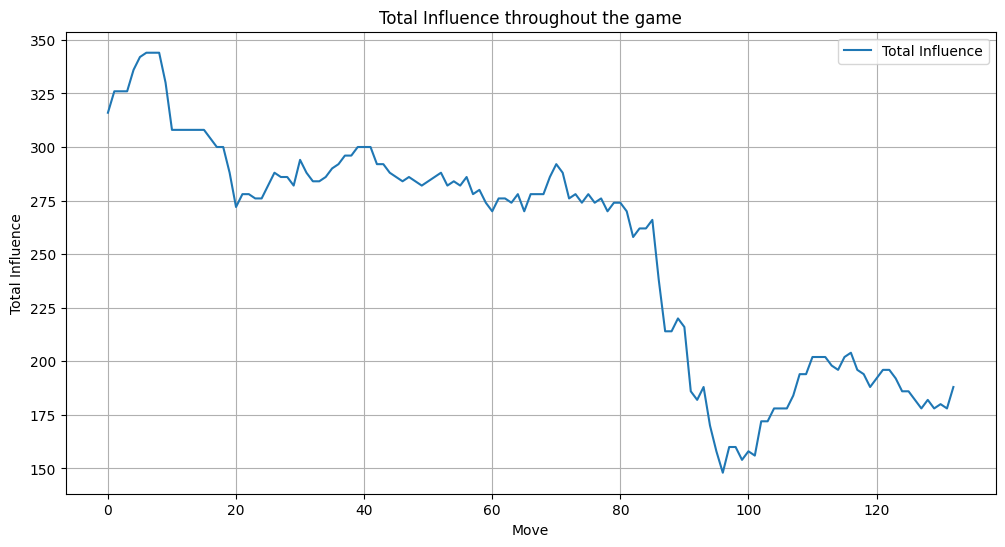

KL Divergence range: inf to inf
JS Divergence range: 0.023801501344953527 to 0.35985237108172
Total Influence range: 148.0 to 344.0


In [46]:
import torch
import chess
import chess.svg
import numpy as np
import matplotlib.pyplot as plt
from cairosvg import svg2png
from PIL import Image
import io

# def board_to_tensor(board):
#     piece_to_index = {
#         'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
#         'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
#     }
#     tensor = torch.zeros(12, 8, 8)
#     for square, piece in board.piece_map().items():
#         rank, file = divmod(square, 8)
#         tensor[piece_to_index[piece.symbol()]][7-rank][file] = 1
#     return tensor

# def create_influence_channels(board_tensor):
#     influence_channels = torch.zeros(12, 8, 8)
    
#     # Pawn influences
#     white_pawn = board_tensor[0]
#     black_pawn = board_tensor[6]
#     influence_channels[0, :-1, 1:] += white_pawn[1:, :-1]  # Diagonal right
#     influence_channels[0, :-1, :-1] += white_pawn[1:, 1:]  # Diagonal left
#     influence_channels[6, 1:, 1:] += black_pawn[:-1, :-1]  # Diagonal right
#     influence_channels[6, 1:, :-1] += black_pawn[:-1, 1:]  # Diagonal left
    
#     # Knight influences
#     knight_kernel = torch.tensor([
#         [0,1,0,1,0],
#         [1,0,0,0,1],
#         [0,0,0,0,0],
#         [1,0,0,0,1],
#         [0,1,0,1,0]
#     ]).float()
#     influence_channels[1] = torch.nn.functional.conv2d(board_tensor[1].unsqueeze(0).unsqueeze(0), knight_kernel.unsqueeze(0).unsqueeze(0), padding=2)[0, 0]
#     influence_channels[7] = torch.nn.functional.conv2d(board_tensor[7].unsqueeze(0).unsqueeze(0), knight_kernel.unsqueeze(0).unsqueeze(0), padding=2)[0, 0]
    
#     # Sliding piece influences (Bishop, Rook, Queen)
#     for i, directions in enumerate([(1,1), (1,0), (1,1)]):  # Bishop, Rook, Queen
#         white_influence = torch.zeros(8, 8)
#         black_influence = torch.zeros(8, 8)
#         for dx, dy in [directions, (-directions[0], directions[1]), (directions[0], -directions[1]), (-directions[0], -directions[1])]:
#             ray = torch.zeros(8, 8)
#             x, y = 3, 3
#             while 0 <= x < 8 and 0 <= y < 8:
#                 ray[x, y] = 1
#                 x, y = x + dx, y + dy
#             white_influence += torch.nn.functional.conv2d(board_tensor[i+2].unsqueeze(0).unsqueeze(0), ray.unsqueeze(0).unsqueeze(0), padding='same')[0, 0]
#             black_influence += torch.nn.functional.conv2d(board_tensor[i+8].unsqueeze(0).unsqueeze(0), ray.unsqueeze(0).unsqueeze(0), padding='same')[0, 0]
#         influence_channels[i+2] = white_influence
#         influence_channels[i+8] = black_influence
    
#     # King influences
#     king_kernel = torch.tensor([
#         [1,1,1],
#         [1,0,1],
#         [1,1,1]
#     ]).float()
#     influence_channels[5] = torch.nn.functional.conv2d(board_tensor[5].unsqueeze(0).unsqueeze(0), king_kernel.unsqueeze(0).unsqueeze(0), padding=1)[0, 0]
#     influence_channels[11] = torch.nn.functional.conv2d(board_tensor[11].unsqueeze(0).unsqueeze(0), king_kernel.unsqueeze(0).unsqueeze(0), padding=1)[0, 0]
    
#     return influence_channels

# def combine_influences(influence_channels):
#     white_influence = influence_channels[:6].sum(dim=0)
#     black_influence = influence_channels[6:].sum(dim=0)
    
#     # Calculate total influence and control
#     total_influence = white_influence + black_influence
#     control = torch.tanh(white_influence - black_influence)
    
#     return total_influence, control

# def create_jepa_mask(influence_map, mask_ratio=0.25):
#     num_squares = influence_map.numel()
#     num_masked = int(num_squares * mask_ratio)
#     _, indices = torch.topk(influence_map.flatten(), k=num_masked)
#     mask = torch.ones_like(influence_map, dtype=torch.bool)
#     mask.view(-1)[indices] = False
# # return mask
def board_to_tensor(board):
    piece_to_index = {'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
                      'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11}
    tensor = torch.zeros(13, 8, 8, dtype=torch.float32)
    for square, piece in board.piece_map().items():
        rank, file = divmod(square, 8)
        tensor[piece_to_index[piece.symbol()]][7-rank][file] = 1
    
    # Add a channel for empty squares
    tensor[12] = 1 - tensor.sum(dim=0)
    
    # Add channels for color-agnostic piece positions and side to move
    tensor = torch.cat([
        tensor,
        tensor[:6] + tensor[6:12],
        torch.full((1, 8, 8), float(board.turn))
    ], dim=0)
    
    return tensor

def create_influence_channels(board_tensor):
    influence_channels = torch.zeros(14, 8, 8, dtype=torch.float32)
    
    # Pawn influences (including en passant)
    white_pawn = board_tensor[0]
    black_pawn = board_tensor[6]
    influence_channels[0, :-1, 1:] += white_pawn[1:, :-1]  # Diagonal right
    influence_channels[0, :-1, :-1] += white_pawn[1:, 1:]  # Diagonal left
    influence_channels[6, 1:, 1:] += black_pawn[:-1, :-1]  # Diagonal right
    influence_channels[6, 1:, :-1] += black_pawn[:-1, 1:]  # Diagonal left
    
    # En passant
    if board_tensor[-1, 0, 0] == 1:  # White to move
        ep_file = (board_tensor[12] == 0).float().sum(dim=0).argmax()
        if ep_file > 0:
            influence_channels[0, 2, ep_file-1] = 1
        if ep_file < 7:
            influence_channels[0, 2, ep_file+1] = 1
    else:
        ep_file = (board_tensor[12] == 0).float().sum(dim=0).argmax()
        if ep_file > 0:
            influence_channels[6, 5, ep_file-1] = 1
        if ep_file < 7:
            influence_channels[6, 5, ep_file+1] = 1
    
    # Knight influences
    knight_kernel = torch.tensor([
        [0,1,0,1,0],
        [1,0,0,0,1],
        [0,0,0,0,0],
        [1,0,0,0,1],
        [0,1,0,1,0]
    ], dtype=torch.float32)
    influence_channels[1] = torch.nn.functional.conv2d(board_tensor[1].unsqueeze(0).unsqueeze(0), knight_kernel.unsqueeze(0).unsqueeze(0), padding=2)[0, 0]
    influence_channels[7] = torch.nn.functional.conv2d(board_tensor[7].unsqueeze(0).unsqueeze(0), knight_kernel.unsqueeze(0).unsqueeze(0), padding=2)[0, 0]
    
    # Sliding piece influences (Bishop, Rook, Queen)
    for i, directions in enumerate([(1,1), (1,0), (1,1)]):  # Bishop, Rook, Queen
        white_influence = torch.zeros(8, 8, dtype=torch.float32)
        black_influence = torch.zeros(8, 8, dtype=torch.float32)
        for dx, dy in [directions, (-directions[0], directions[1]), (directions[0], -directions[1]), (-directions[0], -directions[1])]:
            ray = torch.zeros(8, 8, dtype=torch.float32)
            x, y = 3, 3
            while 0 <= x < 8 and 0 <= y < 8:
                ray[x, y] = 1
                x, y = x + dx, y + dy
            white_influence += torch.nn.functional.conv2d(board_tensor[i+2].unsqueeze(0).unsqueeze(0), ray.unsqueeze(0).unsqueeze(0), padding='same')[0, 0]
            black_influence += torch.nn.functional.conv2d(board_tensor[i+8].unsqueeze(0).unsqueeze(0), ray.unsqueeze(0).unsqueeze(0), padding='same')[0, 0]
        influence_channels[i+2] = white_influence
        influence_channels[i+8] = black_influence
    
    # King influences
    king_kernel = torch.tensor([
        [1,1,1],
        [1,0,1],
        [1,1,1]
    ], dtype=torch.float32)
    influence_channels[5] = torch.nn.functional.conv2d(board_tensor[5].unsqueeze(0).unsqueeze(0), king_kernel.unsqueeze(0).unsqueeze(0), padding=1)[0, 0]
    influence_channels[11] = torch.nn.functional.conv2d(board_tensor[11].unsqueeze(0).unsqueeze(0), king_kernel.unsqueeze(0).unsqueeze(0), padding=1)[0, 0]
    
    # Add channels for total influence
    influence_channels[12] = influence_channels[:6].sum(dim=0)  # White total influence
    influence_channels[13] = influence_channels[6:12].sum(dim=0)  # Black total influence
    
    return influence_channels

def combine_influences(influence_channels):
    white_influence = influence_channels[:6].sum(dim=0)
    black_influence = influence_channels[6:12].sum(dim=0)
    
    # Calculate total influence and control
    total_influence = white_influence + black_influence
    control = torch.tanh(white_influence - black_influence)
    
    # Calculate tension (squares contested by both sides)
    tension = torch.min(white_influence, black_influence)
    
    # Calculate mobility (number of legal moves for each piece)
    white_mobility = influence_channels[:6].sum()
    black_mobility = influence_channels[6:12].sum()
    
    return {
        'total_influence': total_influence,
        'control': control,
        'tension': tension,
        'white_mobility': white_mobility,
        'black_mobility': black_mobility
    }

def create_jepa_mask(influence_map, mask_ratio=0.25, min_region_size=2, max_region_size=4):
    num_squares = influence_map.numel()
    num_masked = int(num_squares * mask_ratio)
    
    # Create initial mask based on influence
    _, indices = torch.topk(influence_map.flatten(), k=num_masked)
    mask = torch.ones_like(influence_map, dtype=torch.bool)
    mask.view(-1)[indices] = False
    
    # Expand mask regions
    for _ in range(max_region_size - 1):
        expanded_mask = torch.nn.functional.max_pool2d(
            (~mask).float().unsqueeze(0).unsqueeze(0),
            kernel_size=3, stride=1, padding=1
        ).squeeze(0).squeeze(0).bool()
        mask = ~expanded_mask
        
        if (~mask).sum() >= num_masked * max_region_size / min_region_size:
            break
    
    # Trim excess masked squares
    excess = (~mask).sum() - num_masked
    if excess > 0:
        trim_indices = torch.randperm((~mask).sum())[:excess]
        mask[~mask] |= torch.zeros((~mask).sum(), dtype=torch.bool).scatter_(0, trim_indices, True)
    
    return mask

def board_to_image(board):
    svg = chess.svg.board(board=board, size=400)
    png = svg2png(bytestring=svg)
    return Image.open(io.BytesIO(png))

def plot_board_with_overlay(ax, board_image, overlay_data, title, cmap='coolwarm'):
    ax.imshow(board_image)
    overlay = ax.imshow(overlay_data, cmap=cmap, alpha=0.6, vmin=-1, vmax=1)
    ax.set_title(title)
    ax.axis('off')
    return overlay

# # Set up the chess game
# board = chess.Board()
# moves = [
#     "d4", "Nf6", "c4", "e6", "Nc3", "Bb4", "e3", "O-O", "Bd3", "d5", "Nf3", "c5", "O-O", "cxd4", "exd4", "dxc4",
#     "Bxc4", "b6", "Bg5", "Bb7", "Re1", "Nbd7", "Rc1", "Rc8", "Qb3", "Be7", "Bxf6", "Nxf6", "Bxe6", "fxe6",
#     "Qxe6+", "Kh8", "Qxe7", "Bxf3", "gxf3", "Qxd4", "Nb5", "Qxb2", "Rxc8", "Rxc8", "Nd6", "Rb8", "Nf7+", "Kg8",
#     "Qe6", "Rf8", "Nd8+", "Kh8", "Qe7"
# ]

# for move in moves:
#     board.push_san(move)

# # Create board tensor and influence channels
# board_tensor = board_to_tensor(board)
# influence_channels = create_influence_channels(board_tensor)

# # Combine influences
# total_influence, control = combine_influences(influence_channels)

# # Create JEPA-like mask
# jepa_mask = create_jepa_mask(total_influence)

# # Visualize the results
# fig, axs = plt.subplots(1, 4, figsize=(25, 6))

# board_image = np.array(board_to_image(board))

# axs[0].imshow(board_image)
# axs[0].set_title("Chess Board")
# axs[0].axis('off')

# influence_overlay = plot_board_with_overlay(axs[1], board_image, total_influence.numpy(), "Total Influence", cmap='viridis')
# control_overlay = plot_board_with_overlay(axs[2], board_image, control.numpy(), "Board Control")
# mask_overlay = plot_board_with_overlay(axs[3], board_image, ~jepa_mask.numpy(), "JEPA-like Mask", cmap='binary')

# plt.colorbar(influence_overlay, ax=axs[1], fraction=0.046, pad=0.04)
# plt.colorbar(control_overlay, ax=axs[2], fraction=0.046, pad=0.04)
# plt.colorbar(mask_overlay, ax=axs[3], fraction=0.046, pad=0.04)

# plt.tight_layout()
# plt.show()

# print("Total Influence:")
# print(total_influence.numpy())
# print("\nBoard Control (positive for white, negative for black):")
# print(control.numpy())
# print("\nJEPA-like mask (True = masked, False = visible):")
# print(jepa_mask.numpy())

# def analyze_game_sequence(moves):
#     board = chess.Board()
#     influence_history = []
#     control_history = []

#     for move in moves:
#         board.push_san(move)
#         board_tensor = board_to_tensor(board)
#         influence_channels = create_influence_channels(board_tensor)
#         total_influence, control = combine_influences(influence_channels)
#         influence_history.append(total_influence.numpy())
#         control_history.append(control.numpy())

#     return influence_history, control_history

# def plot_game_progression(influence_history, control_history, moves, num_positions=8):
#     num_moves = len(influence_history)
#     positions_to_show = np.linspace(0, num_moves - 1, num_positions, dtype=int)

#     fig, axs = plt.subplots(2, num_positions, figsize=(4 * num_positions, 8))

#     for i, move_index in enumerate(positions_to_show):
#         influence = influence_history[move_index]
#         control = control_history[move_index]

#         im1 = axs[0, i].imshow(influence, cmap='viridis')
#         axs[0, i].set_title(f"Influence (Move {move_index + 1})\n{moves[move_index]}")
#         axs[0, i].axis('off')
#         plt.colorbar(im1, ax=axs[0, i], fraction=0.046, pad=0.04)

#         im2 = axs[1, i].imshow(control, cmap='coolwarm', vmin=-1, vmax=1)
#         axs[1, i].set_title(f"Control (Move {move_index + 1})\n{moves[move_index]}")
#         axs[1, i].axis('off')
#         plt.colorbar(im2, ax=axs[1, i], fraction=0.046, pad=0.04)

#     plt.tight_layout()
#     plt.show()
from typing import List, Dict, Tuple

def analyze_game_sequence(moves: List[str]) -> Dict[str, List[torch.Tensor]]:
    board = chess.Board()
    history = {
        'influence': [],
        'control': [],
        'tension': [],
        'white_mobility': [],
        'black_mobility': [],
        'board_tensors': [],
        'influence_channels': []
    }
    
    for move in moves:
        board.push_san(move)
        board_tensor = board_to_tensor(board)
        influence_channels = create_influence_channels(board_tensor)
        metrics = combine_influences(influence_channels)
        
        history['board_tensors'].append(board_tensor)
        history['influence_channels'].append(influence_channels)
        history['influence'].append(metrics['total_influence'])
        history['control'].append(metrics['control'])
        history['tension'].append(metrics['tension'])
        history['white_mobility'].append(metrics['white_mobility'])
        history['black_mobility'].append(metrics['black_mobility'])
    
    return history

def plot_game_progression(history: Dict[str, List[torch.Tensor]], moves: List[str], num_positions: int = 8):
    num_moves = len(history['influence'])
    positions_to_show = np.linspace(0, num_moves - 1, num_positions, dtype=int)
    
    fig, axs = plt.subplots(3, num_positions, figsize=(4 * num_positions, 12))
    
    for i, move_index in enumerate(positions_to_show):
        influence = history['influence'][move_index].numpy()
        control = history['control'][move_index].numpy()
        tension = history['tension'][move_index].numpy()
        
        im1 = axs[0, i].imshow(influence, cmap='viridis')
        axs[0, i].set_title(f"Influence (Move {move_index + 1})\n{moves[move_index]}")
        axs[0, i].axis('off')
        plt.colorbar(im1, ax=axs[0, i], fraction=0.046, pad=0.04)
        
        im2 = axs[1, i].imshow(control, cmap='coolwarm', vmin=-1, vmax=1)
        axs[1, i].set_title(f"Control (Move {move_index + 1})\n{moves[move_index]}")
        axs[1, i].axis('off')
        plt.colorbar(im2, ax=axs[1, i], fraction=0.046, pad=0.04)
        
        im3 = axs[2, i].imshow(tension, cmap='hot', vmin=0, vmax=2)
        axs[2, i].set_title(f"Tension (Move {move_index + 1})\n{moves[move_index]}")
        axs[2, i].axis('off')
        plt.colorbar(im3, ax=axs[2, i], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Plot mobility
    plt.figure(figsize=(12, 6))
    plt.plot(history['white_mobility'], label='White Mobility')
    plt.plot(history['black_mobility'], label='Black Mobility')
    plt.xlabel('Move Number')
    plt.ylabel('Mobility')
    plt.title('Mobility Throughout the Game')
    plt.legend()
    plt.grid(True)
    plt.show()

def analyze_and_plot_game(moves: List[str], num_positions: int = 8):
    history = analyze_game_sequence(moves)
    plot_game_progression(history, moves, num_positions)
    return history

def find_critical_moments(history: Dict[str, List[torch.Tensor]], threshold: float = 0.5) -> List[int]:
    """
    Identify critical moments in the game based on significant changes in board control.
    
    Args:
    history (Dict[str, List[torch.Tensor]]): Game history containing control tensors.
    threshold (float): The minimum change in control to be considered critical.
    
    Returns:
    List[int]: Indices of critical moments.
    """
    control_changes = [torch.abs(history['control'][i+1] - history['control'][i]).max().item() 
                       for i in range(len(history['control']) - 1)]
    critical_moments = [i for i, change in enumerate(control_changes) if change > threshold]
    return critical_moments

def plot_jepa_masks(history: Dict[str, List[torch.Tensor]], moves: List[str], num_positions: int = 8):
    num_moves = len(history['influence'])
    positions_to_show = np.linspace(0, num_moves - 1, num_positions, dtype=int)
    
    fig, axs = plt.subplots(2, num_positions, figsize=(4 * num_positions, 8))
    
    for i, move_index in enumerate(positions_to_show):
        board_tensor = history['board_tensors'][move_index]
        influence_channels = history['influence_channels'][move_index]
        
        # Create JEPA mask
        combined_tensor = torch.cat([board_tensor, influence_channels], dim=0)
        mask = create_jepa_mask(combined_tensor.sum(dim=0))
        
        # Plot board state
        axs[0, i].imshow(board_tensor.sum(dim=0).numpy(), cmap='viridis')
        axs[0, i].set_title(f"Board State (Move {move_index + 1})\n{moves[move_index]}")
        axs[0, i].axis('off')
        
        # Plot JEPA mask
        mask_img = axs[1, i].imshow(mask.float().numpy(), cmap='gray_r')
        axs[1, i].set_title(f"JEPA Mask (Move {move_index + 1})")
        axs[1, i].axis('off')
        plt.colorbar(mask_img, ax=axs[1, i], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

def analyze_alphazero_immortal_with_jepa():
    # Analyze the game sequence
    game_history = analyze_game_sequence(moves)
    
    # Plot the game progression
    plot_game_progression(game_history, moves)
    
    # Plot JEPA masks
    plot_jepa_masks(game_history, moves)
    
    # Print final metrics
    print("Final Total Influence:")
    print(game_history['influence'][-1].numpy())
    print("\nFinal Board Control (positive for white, negative for black):")
    print(game_history['control'][-1].numpy())
    print("\nFinal Tension:")
    print(game_history['tension'][-1].numpy())
    print("\nFinal White Mobility:", game_history['white_mobility'][-1].item())
    print("\nFinal Black Mobility:", game_history['black_mobility'][-1].item())
    
    # Plot mobility throughout the game
    plt.figure(figsize=(12, 6))
    plt.plot(game_history['white_mobility'], label='White Mobility')
    plt.plot(game_history['black_mobility'], label='Black Mobility')
    plt.xlabel('Move Number')
    plt.ylabel('Mobility')
    plt.title('Mobility Throughout AlphaZero\'s Immortal Game')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Analyze critical moments
    critical_moments = find_critical_moments(game_history)
    print("\nCritical Moments (move numbers):")
    print([moment + 1 for moment in critical_moments])
    
    # Plot control and JEPA masks at critical moments
    num_critical = min(5, len(critical_moments))
    fig, axs = plt.subplots(2, num_critical, figsize=(4 * num_critical, 8))
    for i, moment in enumerate(critical_moments[:num_critical]):
        # Plot control
        im1 = axs[0, i].imshow(game_history['control'][moment].numpy(), cmap='coolwarm', vmin=-1, vmax=1)
        axs[0, i].set_title(f"Control (Move {moment + 1})\n{moves[moment]}")
        axs[0, i].axis('off')
        plt.colorbar(im1, ax=axs[0, i], fraction=0.046, pad=0.04)
        
        # Plot JEPA mask
        combined_tensor = torch.cat([game_history['board_tensors'][moment], game_history['influence_channels'][moment]], dim=0)
        mask = create_jepa_mask(combined_tensor.sum(dim=0))
        im2 = axs[1, i].imshow(mask.float().numpy(), cmap='gray_r')
        axs[1, i].set_title(f"JEPA Mask (Move {moment + 1})")
        axs[1, i].axis('off')
        plt.colorbar(im2, ax=axs[1, i], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    return game_history

# vladimir borisovich's win
moves = [
    "d4", "Nf6", "c4", "e6", "Nc3", "Bb4", "e3", "O-O", "Bd3", "d5", "Nf3", "c5", "O-O", "cxd4", "exd4", "dxc4",
    "Bxc4", "b6", "Bg5", "Bb7", "Re1", "Nbd7", "Rc1", "Rc8", "Qb3", "Be7", "Bxf6", "Nxf6", "Bxe6", "fxe6",
    "Qxe6+", "Kh8", "Qxe7", "Bxf3", "gxf3", "Qxd4", "Nb5", "Qxb2", "Rxc8", "Rxc8", "Nd6", "Rb8", "Nf7+", "Kg8",
    "Qe6", "Rf8", "Nd8+", "Kh8", "Qe7"
]

# # Analyze the game sequence
# influence_history, control_history = analyze_game_sequence(moves)

# # Plot the game progression
# plot_game_progression(influence_history, control_history)

# # Print final influence and control
# print("Final Total Influence:")
# print(influence_history[-1])
# print("\nFinal Board Control (positive for white, negative for black):")
# print(control_history[-1])

# # AlphaZero's Immortal game
# moves = [
#     "Nf3", "Nf6", "c4", "e6", "Nc3", "Bb4", "Qc2", "O-O", "a3", "Bxc3", "Qxc3", "a5", "b4", "d6", "e3", "Ne4", 
#     "Qc2", "Ng5", "b5", "Nxf3+", "gxf3", "Qf6", "d4", "Qxf3", "Rg1", "Nd7", "Be2", "Qf6", "Bb2", "Qh4", "Rg4", 
#     "Qxh2", "Rg3", "f5", "O-O-O", "Rf7", "Bf3", "Qh4", "Rh1", "Qf6", "Kb1", "g6", "Rgg1", "a4", "Ka1", "Rg7", 
#     "e4", "f4", "c5", "Qe7", "Rc1", "Nf6", "e5", "dxe5", "Rhe1", "e4", "Bxe4", "Qf8", "d5", "exd5", "Bd3", 
#     "Bg4", "f3", "Bd7", "Qc3", "Nh5", "Re5", "c6", "Rce1", "Nf6", "Qd4", "cxb5", "Bb1", "Bc6", "Re6", "Rf7", 
#     "Rg1", "Qg7", "Qxf4", "Re8", "Rd6", "Nd7", "Qc1", "Rf6", "f4", "Qe7", "Rxf6", "Nxf6", "f5", "Qe3", "fxg6", 
#     "Qxc1", "gxh7+", "Kf7", "Rxc1", "Nxh7", "Bxh7", "Re3", "Rd1", "Ke8", "Ka2", "Bd7", "Bd4", "Rh3", "Bc2", 
#     "Be6", "Re1", "Kd7", "Kb2", "Rf3", "Re5", "Rg3", "Re3", "Rg2", "Kc3", "Rg4", "Rf3", "Ke8", "Rf2", "Rg3+", 
#     "Kb4", "Rg4", "Rd2", "Bd7", "Ka5", "Rf4", "Be5", "Rf3", "Rd3", "Rf2", "Bd1", "Bc6", "Kb6"
# ]

# # Analyze the game sequence
# influence_history, control_history = analyze_game_sequence(moves)

# # Plot the game progression
# plot_game_progression(influence_history, control_history, moves)

# # Print final influence and control
# print("Final Total Influence:")
# print(influence_history[-1])
# print("\nFinal Board Control (positive for white, negative for black):")
# print(control_history[-1])

# AlphaZero's Immortal game moves
moves = [
    "Nf3", "Nf6", "c4", "e6", "Nc3", "Bb4", "Qc2", "O-O", "a3", "Bxc3", "Qxc3", "a5", "b4", "d6", "e3", "Ne4",
    "Qc2", "Ng5", "b5", "Nxf3+", "gxf3", "Qf6", "d4", "Qxf3", "Rg1", "Nd7", "Be2", "Qf6", "Bb2", "Qh4", "Rg4",
    "Qxh2", "Rg3", "f5", "O-O-O", "Rf7", "Bf3", "Qh4", "Rh1", "Qf6", "Kb1", "g6", "Rgg1", "a4", "Ka1", "Rg7",
    "e4", "f4", "c5", "Qe7", "Rc1", "Nf6", "e5", "dxe5", "Rhe1", "e4", "Bxe4", "Qf8", "d5", "exd5", "Bd3",
    "Bg4", "f3", "Bd7", "Qc3", "Nh5", "Re5", "c6", "Rce1", "Nf6", "Qd4", "cxb5", "Bb1", "Bc6", "Re6", "Rf7",
    "Rg1", "Qg7", "Qxf4", "Re8", "Rd6", "Nd7", "Qc1", "Rf6", "f4", "Qe7", "Rxf6", "Nxf6", "f5", "Qe3", "fxg6",
    "Qxc1", "gxh7+", "Kf7", "Rxc1", "Nxh7", "Bxh7", "Re3", "Rd1", "Ke8", "Ka2", "Bd7", "Bd4", "Rh3", "Bc2",
    "Be6", "Re1", "Kd7", "Kb2", "Rf3", "Re5", "Rg3", "Re3", "Rg2", "Kc3", "Rg4", "Rf3", "Ke8", "Rf2", "Rg3+",
    "Kb4", "Rg4", "Rd2", "Bd7", "Ka5", "Rf4", "Be5", "Rf3", "Rd3", "Rf2", "Bd1", "Bc6", "Kb6"
]
import torch
import numpy as np
from scipy.special import kl_div
from scipy.spatial.distance import jensenshannon

def update_ema(current_ema: torch.Tensor, new_value: torch.Tensor, alpha: float = 0.1) -> torch.Tensor:
    """
    Update the exponential moving average.
    
    Args:
    current_ema (torch.Tensor): Current EMA tensor
    new_value (torch.Tensor): New tensor to incorporate
    alpha (float): EMA weight (0 < alpha <= 1)
    
    Returns:
    torch.Tensor: Updated EMA
    """
    return alpha * new_value + (1 - alpha) * current_ema

def calculate_kl_divergence(p: np.ndarray, q: np.ndarray) -> float:
    """
    Calculate KL divergence between two distributions.
    
    Args:
    p (np.ndarray): First distribution
    q (np.ndarray): Second distribution
    
    Returns:
    float: KL divergence
    """
    return np.sum(kl_div(p, q))

def calculate_js_divergence(p: np.ndarray, q: np.ndarray) -> float:
    """
    Calculate Jensen-Shannon divergence between two distributions.
    
    Args:
    p (np.ndarray): First distribution
    q (np.ndarray): Second distribution
    
    Returns:
    float: JS divergence
    """
    return jensenshannon(p, q, base=2)**2

def analyze_game_sequence_with_ema_divergence(moves: List[str]) -> Dict[str, List[float]]:
    board = chess.Board()
    history = {
        'kl_divergence': [],
        'js_divergence': [],
        'total_influence': []
    }
    
    ema_influence = None
    
    for move in moves:
        board.push_san(move)
        board_tensor = board_to_tensor(board)
        influence_channels = create_influence_channels(board_tensor)
        
        # Flatten and normalize influence channels
        flat_influence = influence_channels.view(-1)
        norm_influence = flat_influence / (flat_influence.sum() + 1e-10)
        
        if ema_influence is None:
            ema_influence = norm_influence
        else:
            # Calculate divergences
            kl_div = calculate_kl_divergence(ema_influence.numpy(), norm_influence.numpy())
            js_div = calculate_js_divergence(ema_influence.numpy(), norm_influence.numpy())
            
            history['kl_divergence'].append(kl_div)
            history['js_divergence'].append(js_div)
            
            # Update EMA
            ema_influence = update_ema(ema_influence, norm_influence)
        
        history['total_influence'].append(flat_influence.sum().item())
    
    return history

# Analyze the game with EMA and divergence
ema_divergence_history = analyze_game_sequence_with_ema_divergence(moves)

# Plot KL and JS divergences
plt.figure(figsize=(12, 6))
plt.plot(ema_divergence_history['kl_divergence'], label='KL Divergence')
plt.plot(ema_divergence_history['js_divergence'], label='JS Divergence')
plt.xlabel('Move')
plt.ylabel('Divergence')
plt.title('KL and JS Divergences of Influence EMA throughout the game')
plt.legend()
plt.grid(True)
plt.show()

# Plot total influence
plt.figure(figsize=(12, 6))
plt.plot(ema_divergence_history['total_influence'], label='Total Influence')
plt.xlabel('Move')
plt.ylabel('Total Influence')
plt.title('Total Influence throughout the game')
plt.legend()
plt.grid(True)
plt.show()

# Print some statistics
print("KL Divergence range:", min(ema_divergence_history['kl_divergence']), "to", max(ema_divergence_history['kl_divergence']))
print("JS Divergence range:", min(ema_divergence_history['js_divergence']), "to", max(ema_divergence_history['js_divergence']))
print("Total Influence range:", min(ema_divergence_history['total_influence']), "to", max(ema_divergence_history['total_influence']))

# def analyze_alphazero_immortal():
#     # Analyze the game sequence
#     game_history = analyze_game_sequence(moves)
    
#     # Plot the game progression
#     plot_game_progression(game_history, moves)
    
#     # Print final metrics
#     print("Final Total Influence:")
#     print(game_history['influence'][-1].numpy())
#     print("\nFinal Board Control (positive for white, negative for black):")
#     print(game_history['control'][-1].numpy())
#     print("\nFinal Tension:")
#     print(game_history['tension'][-1].numpy())
#     print("\nFinal White Mobility:", game_history['white_mobility'][-1].item())
#     print("Final Black Mobility:", game_history['black_mobility'][-1].item())
    
#     # Plot mobility throughout the game
#     plt.figure(figsize=(12, 6))
#     plt.plot(game_history['white_mobility'], label='White Mobility')
#     plt.plot(game_history['black_mobility'], label='Black Mobility')
#     plt.xlabel('Move Number')
#     plt.ylabel('Mobility')
#     plt.title('Mobility Throughout AlphaZero\'s Immortal Game')
#     plt.legend()
#     plt.grid(True)
#     plt.show()
    
#     return game_history

# # # Run the analysis
# # alphazero_immortal_history = analyze_alphazero_immortal_with_jepa()

# from scipy.stats import entropy
# import torch.nn.functional as F
# import math

# def calculate_influence_entropy(influence_channels: torch.Tensor) -> torch.Tensor:
#     """
#     Calculate entropy based on the influence maps from our tensor representation.
    
#     Args:
#     influence_channels (torch.Tensor): The influence channels tensor
    
#     Returns:
#     torch.Tensor: Entropy scalar
#     """
#     # Separate white and black influence
#     white_influence = influence_channels[:6].sum(dim=0)
#     black_influence = influence_channels[6:12].sum(dim=0)
    
#     # Normalize influences
#     total_influence = white_influence + black_influence
#     white_prob = white_influence / (total_influence + 1e-10)
#     black_prob = black_influence / (total_influence + 1e-10)
    
#     # Calculate entropy for each square
#     square_entropy = -(white_prob * torch.log2(white_prob + 1e-10) + 
#                        black_prob * torch.log2(black_prob + 1e-10))
    
#     # Weight entropy by total influence
#     weighted_entropy = square_entropy * total_influence
    
#     # Sum entropy across the board
#     total_entropy = weighted_entropy.sum()
    
#     return total_entropy

# def analyze_game_sequence_with_influence_entropy(moves: List[str]) -> Dict[str, List[torch.Tensor]]:
#     board = chess.Board()
#     history = {
#         'entropy': [],
#         'total_influence': []
#     }
    
#     for move in moves:
#         board.push_san(move)
#         board_tensor = board_to_tensor(board)
#         influence_channels = create_influence_channels(board_tensor)
        
#         entropy = calculate_influence_entropy(influence_channels)
#         total_influence = influence_channels.sum()
        
#         history['entropy'].append(entropy)
#         history['total_influence'].append(total_influence)
    
#     return history

# # Analyze the game with influence-based entropy
# influence_entropy_history = analyze_game_sequence_with_influence_entropy(moves)

# # Plot influence-based entropy
# plt.figure(figsize=(12, 6))
# plt.plot([e.item() for e in influence_entropy_history['entropy']], label='Influence Entropy')
# plt.plot([t.item() for t in influence_entropy_history['total_influence']], label='Total Influence')
# plt.xlabel('Move')
# plt.ylabel('Value')
# plt.title('Chess Influence Entropy and Total Influence throughout the game')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Print some statistics
# print("Entropy range:", min(influence_entropy_history['entropy']).item(), "to", max(influence_entropy_history['entropy']).item())
# print("Total influence range:", min(influence_entropy_history['total_influence']).item(), "to", max(influence_entropy_history['total_influence']).item())

# def analyze_game_sequence(moves):
#     board = chess.Board()
#     influence_history = []
#     control_history = []
#     influence_shifts = []
#     control_shifts = []

#     for move in moves:
#         board.push_san(move)
#         board_tensor = board_to_tensor(board)
#         influence_channels = create_influence_channels(board_tensor)
#         total_influence, control = combine_influences(influence_channels)
        
#         influence_history.append(total_influence.numpy())
#         control_history.append(control.numpy())
        
#         if len(influence_history) > 1:
#             influence_shift = np.sum(np.abs(influence_history[-1] - influence_history[-2]))
#             control_shift = np.sum(np.abs(control_history[-1] - control_history[-2]))
#             influence_shifts.append(influence_shift)
#             control_shifts.append(control_shift)

#     return influence_history, control_history, influence_shifts, control_shifts

# def plot_game_stats(moves, influence_shifts, control_shifts):
#     plt.figure(figsize=(15, 10))
    
#     plt.subplot(2, 1, 1)
#     plt.plot(influence_shifts, label='Influence Shift')
#     plt.title('Influence Shifts Throughout the Game')
#     plt.xlabel('Move Number')
#     plt.ylabel('Total Absolute Change')
#     plt.legend()
    
#     plt.subplot(2, 1, 2)
#     plt.plot(control_shifts, label='Control Shift', color='orange')
#     plt.title('Control Shifts Throughout the Game')
#     plt.xlabel('Move Number')
#     plt.ylabel('Total Absolute Change')
#     plt.legend()
    
#     plt.tight_layout()
#     plt.show()

# def identify_key_moves(moves, influence_shifts, control_shifts, top_n=5):
#     combined_shifts = np.array(influence_shifts) + np.array(control_shifts)
#     top_indices = combined_shifts.argsort()[-top_n:][::-1]
    
#     print(f"Top {top_n} Most Impactful Moves:")
#     for i, idx in enumerate(top_indices, 1):
#         print(f"{i}. Move {idx+1}: {moves[idx]} (Influence Shift: {influence_shifts[idx]:.2f}, Control Shift: {control_shifts[idx]:.2f})")

# def calculate_game_stats(influence_history, control_history):
#     influence_array = np.array(influence_history)
#     control_array = np.array(control_history)
    
#     avg_influence = np.mean(influence_array, axis=0)
#     avg_control = np.mean(control_array, axis=0)
    
#     white_advantage = np.sum(control_array > 0, axis=1) / 64  # Percentage of squares controlled by white
#     black_advantage = np.sum(control_array < 0, axis=1) / 64  # Percentage of squares controlled by black
    
#     print("\nGame Statistics:")
#     print(f"Average Total Influence:\n{avg_influence}")
#     print(f"\nAverage Control (positive for white, negative for black):\n{avg_control}")
#     print(f"\nWhite's average board control: {np.mean(white_advantage):.2%}")
#     print(f"Black's average board control: {np.mean(black_advantage):.2%}")
#     print(f"\nLargest white advantage: {np.max(white_advantage):.2%} (Move {np.argmax(white_advantage)+1})")
#     print(f"Largest black advantage: {np.max(black_advantage):.2%} (Move {np.argmax(black_advantage)+1})")

# # AlphaZero's Immortal game moves
# moves = [
#     "Nf3", "Nf6", "c4", "e6", "Nc3", "Bb4", "Qc2", "O-O", "a3", "Bxc3", "Qxc3", "a5", "b4", "d6", "e3", "Ne4", 
#     "Qc2", "Ng5", "b5", "Nxf3+", "gxf3", "Qf6", "d4", "Qxf3", "Rg1", "Nd7", "Be2", "Qf6", "Bb2", "Qh4", "Rg4", 
#     "Qxh2", "Rg3", "f5", "O-O-O", "Rf7", "Bf3", "Qh4", "Rh1", "Qf6", "Kb1", "g6", "Rgg1", "a4", "Ka1", "Rg7", 
#     "e4", "f4", "c5", "Qe7", "Rc1", "Nf6", "e5", "dxe5", "Rhe1", "e4", "Bxe4", "Qf8", "d5", "exd5", "Bd3", 
#     "Bg4", "f3", "Bd7", "Qc3", "Nh5", "Re5", "c6", "Rce1", "Nf6", "Qd4", "cxb5", "Bb1", "Bc6", "Re6", "Rf7", 
#     "Rg1", "Qg7", "Qxf4", "Re8", "Rd6", "Nd7", "Qc1", "Rf6", "f4", "Qe7", "Rxf6", "Nxf6", "f5", "Qe3", "fxg6", 
#     "Qxc1", "gxh7+", "Kf7", "Rxc1", "Nxh7", "Bxh7", "Re3", "Rd1", "Ke8", "Ka2", "Bd7", "Bd4", "Rh3", "Bc2", 
#     "Be6", "Re1", "Kd7", "Kb2", "Rf3", "Re5", "Rg3", "Re3", "Rg2", "Kc3", "Rg4", "Rf3", "Ke8", "Rf2", "Rg3+", 
#     "Kb4", "Rg4", "Rd2", "Bd7", "Ka5", "Rf4", "Be5", "Rf3", "Rd3", "Rf2", "Bd1", "Bc6", "Kb6"
# ]

# # Analyze the game sequence
# influence_history, control_history, influence_shifts, control_shifts = analyze_game_sequence(moves)

# # Plot game statistics
# plot_game_stats(moves, influence_shifts, control_shifts)

# # Identify key moves
# identify_key_moves(moves, influence_shifts, control_shifts)

# # Calculate and print game statistics
# calculate_game_stats(influence_history, control_history)